<a href="https://colab.research.google.com/github/agusrichard/data-science-projects/blob/master/News%20Groups/20_newsgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Modeling: 20 Newsgroups

__Import Libraries__

In [1]:
# Essentials
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Machine Learning
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



# Deep Learning


# Fetch data from sklearn
from sklearn.datasets import fetch_20newsgroups


# Ignore warning
# import warnings
# warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


__Helper function__

In [20]:
def check_none(ls):
    """
    Check is there any NoneType element inside a list
    """
    num_none = 0
    for element in ls:
        if element is None:
            num_none += 1
    return num_none


def cleaning_text(text):
    """
    Cleaning each text with custom specification using Regular Expression

    Parameters
    ----------
    text : str
        Text to clean

    Return
    ------
    Cleaned text
    """

    splitted = text.split('\n')
    email_pattern = re.compile(r"\S+@\S+")      
    special_chars_pattern = re.compile(r"[^\w\s'\"_]")
    space_pattern = re.compile(r"\s+")
    num_pattern = re.compile(r"\d+")

    for i in range(len(splitted)):

        # Replace the sentence which startswith From, Subject, In-Reply-To, Organization, Lines (header)
        # with single white space
        if splitted[i].startswith('From:') or splitted[i].startswith('Subject:') or \
                splitted[i].startswith('In-Reply-To') or splitted[i].startswith('Organization:') or \
                splitted[i].startswith('Lines:') or splitted[i].startswith('Originator:') or \
                splitted[i].startswith('Nntp-Posting-Host:') or splitted[i].startswith('Distribution:'):
            splitted[i] = ' '

        # Lowercasing text
        splitted[i] = splitted[i].lower()

        # if the sentence contains email, it will be replaced with single white space
        splitted[i] = email_pattern.sub('', splitted[i])

        # Removing some special characters
        splitted[i] = special_chars_pattern.sub('', splitted[i])

        # If more than one white space between words, replace it with single white space
        splitted[i] = space_pattern.sub(' ', splitted[i])

        # Removing numbers
        splitted[i] = num_pattern.sub('', splitted[i])
    
    return ' '.join(splitted).strip()

__Load the data__

In [3]:
bunch_train = fetch_20newsgroups(subset='train')
bunch_test = fetch_20newsgroups(subset='test')

See what kind of keys available in bunch object.

In [4]:
bunch_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
print(bunch_train['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [6]:
# How many data points in training set and test set
print(f'Number of data points in training set: {len(bunch_train.target)}')
print(f'Number of data points in test set: {len(bunch_test.target)}')
print(f'Total data points: {len(bunch_train.target) + len(bunch_test.target)}')

Number of data points in training set: 11314
Number of data points in test set: 7532
Total data points: 18846


In [7]:
# Target names 
bunch_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's check one of the data point in training set, what it looks like?

In [8]:
print(bunch_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







If we see the above text, what it will be classified to? Some text which talked about car or automotive seems pretty reasonable. But what is it actually?

In [9]:
print(bunch_train.target_names[bunch_train.target[0]])

rec.autos


The main purpose of this notebook is to classify newsgroups into one of the twenty possible options. It could be 'rec.autos' which certainly talked about automotive, it could be 'sci.space', or another. Let's start with preliminary step.

---

## Preliminary Step

In the preliminary step, we will evaluate our data. Is it contain null values? Or anything suspicious that will make our model less predictive.

In [10]:
# any missing values in target vector (training and test)
print('Any missing values in training target vector:', np.isnan(bunch_train.target).sum())
print('Any missing values in test target vector: ', np.isnan(bunch_test.target).sum())

Any missing values in training target vector: 0
Any missing values in test target vector:  0


No missing values in target vectors.

In [11]:
# any missing value in feature data (training and test)
print('Any missing values in training feature data:', check_none(bunch_train.data))
print('Any missing values in test feature data:', check_none(bunch_test.data))

Any missing values in training feature data: 0
Any missing values in test feature data: 0


Also no missing values in feature data.

Now, to become more convenience we put feature data (training and test set) also target vector into their own variable.

In [12]:
train_data = bunch_train.data
test_data = bunch_test.data
train_target = bunch_train.target
test_target = bunch_test.target

In [13]:
# Look at 100th data point in feature data
print(train_data[99])

From: tmc@spartan.ac.BrockU.CA (Tim Ciceran)
Subject: Re: Hijaak
Organization: Brock University, St. Catharines Ontario
X-Newsreader: TIN [version 1.1 PL9]
Lines: 15

Haston, Donald Wayne (haston@utkvx.utk.edu) wrote:
: Currently, I use a shareware program called Graphics Workshop.
: What kinds of things will Hijaak do that these shareware programs
: will not do?

I also use Graphic Workshop and the only differences that I know of are that
Hijaak has screen capture capabilities and acn convert to/from a couple of
more file formats (don't know specifically which one).  In the April 13
issue of PC Magazine they test the twelve best selling image capture/convert
utilities, including Hijaak.

TMC.
(tmc@spartan.ac.brocku.ca)





As we can see, our data composed by header and footer, which would not be beneficial or probably make our model tend to overfit. This time, we will remove it manually. (Actually, we can set arguments in "fetch_20newsgroups" function to exclude headers, footers and quotes, but for learning purpose, we will do it manually)

Now, evaluate how many data points for each class in target vector.

In [14]:
# value counts training set
train_count = pd.Series(train_target).value_counts(normalize=True).sort_index()
test_count = pd.Series(test_target).value_counts(normalize=True).sort_index()
train_count.index = bunch_train.target_names
test_count.index = bunch_test.target_names
train_count = train_count.sort_values(ascending=False)
test_count = test_count.sort_values(ascending=False)

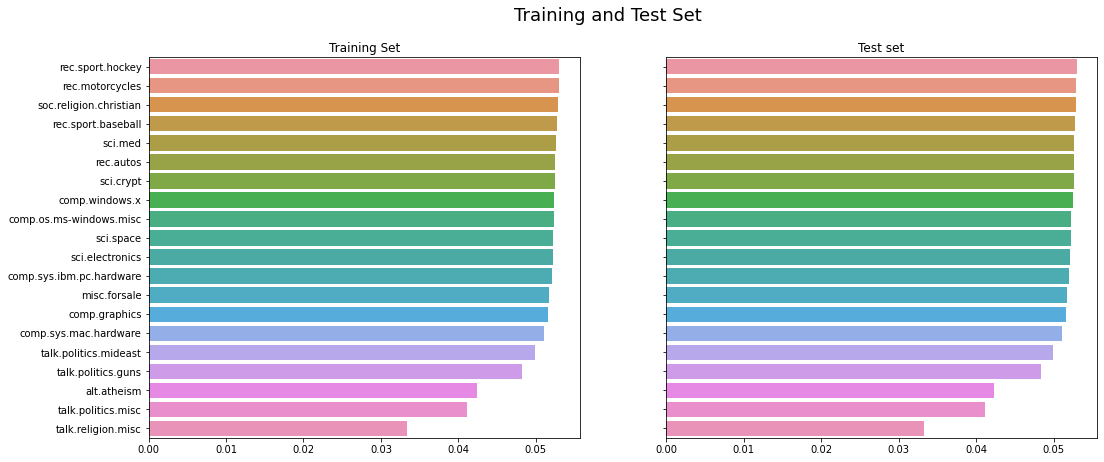

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(17, 7), sharey=True)
sns.barplot(ax=axes[0], x=train_count, y=train_count.index)
axes[0].set(title='Training Set')
sns.barplot(ax=axes[1], x=test_count, y=test_count.index)
axes[1].set(title='Test set')
fig.suptitle('Training and Test Set', fontsize=18);

We have the same distribution in training set and test set. Also the last five topics have lower number of data points, so we have to be careful about imbalance dataset.

---

## Data Cleaning

In the section helper function above, we have defined a function to clean our data.

In [21]:
train_data_cleaned = []
for element in train_data:
    train_data_cleaned.append(cleaning_text(element))

test_data_cleaned = []
for element in test_data:
    test_data_cleaned.append(cleaning_text(element))

__Comparing uncleaned and cleaned data__

In [22]:
# original data
print(train_data[2109])

From: jvigneau@cs.ulowell.edu (Joe Vigneau)
Subject: Re: [soc.motss, et al.] "Princeton axes matching funds for Boy Scouts"
In-Reply-To: bevans@carina.unm.edu's message of 4 Apr 1993 12:19:20 GMT
Organization: -
	<1993Apr3.214557.24073@midway.uchicago.edu> <1pmjo8INN2l0@lynx.unm.edu>
Lines: 21

In article <1pmjo8INN2l0@lynx.unm.edu> bevans@carina.unm.edu (Mathemagician) writes:

   Just what do gay people do that straight people don't?

Absolutely nothing.

I'm a VERY straight(as an arrow), 17-year old male that is involved in the BSA.

I don't care what gay people do among each other, as long as they don't make
passes at me or anything.  At my summer camp where I work, my boss is gay.
Not in a 'pansy' way of gay (I know a few), but just 'one of the guys'.
He doesn't push anything on me, and we give him the same respect back, due
to his position.

If anything, the BSA has taught me, I don't know, tolerance or something.
Before I met this guy, I thought all gays were 'faries'.  So, the 

In [23]:
# cleaned data
print(train_data_cleaned[2109])

in article mathemagician writes   just what do gay people do that straight people don't  absolutely nothing  i'm a very straightas an arrow year old male that is involved in the bsa  i don't care what gay people do among each other as long as they don't make passes at me or anything at my summer camp where i work my boss is gay not in a 'pansy' way of gay i know a few but just 'one of the guys' he doesn't push anything on me and we give him the same respect back due to his position  if anything the bsa has taught me i don't know tolerance or something before i met this guy i thought all gays were 'faries' so the bsa has taught me to be an antibigot  basically it comes down to this what you do among yourself is your own business no one else has the right to tell you otherwise unless it violates someone else's civil rights


Note that we have removed email address, special characters, headers, and numbers. Which probably will impacting our model performance, in the end of this notebook, we will compare whether cleaning the data really improve the performance or not.

---

## Text Vectorization

In this section, we will transform the document set into feature matrix using two vectorizer provided by scikit-learn.

In [29]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

In [33]:
X_train_count = count_vectorizer.fit_transform(train_data_cleaned)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data_cleaned)
X_test_count = count_vectorizer.transform(test_data_cleaned)
X_test_tfidf = tfidf_vectorizer.transform(test_data_cleaned)

In [34]:
print('X_train_count.shape', X_train_count.shape)
print('X_train_tfidf.shape', X_train_tfidf.shape)
print('X_test_count.shape', X_test_count.shape)
print('X_test_tfidf.shape', X_test_tfidf.shape)

X_train_count.shape (11314, 1000)
X_train_tfidf.shape (11314, 1000)
X_test_count.shape (7532, 1000)
X_test_tfidf.shape (7532, 1000)


We preserve only 1000 features to reduce dimensionality.

----